# The miniJPAS survey: star-galaxy classification using machine learning


Codes for graphics used in the paper “The miniJPAS survey: star-galaxy classification using machine learning” (P. O. Baqui, V. Marra et al.) https://arxiv.org/abs/2007.07622

In this code we analysed the data from HSC-SUBARU survey using Morphological parameters together with 
photometric bands.

In [1]:
# import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv('/home/pedro/Desktop/pendrive/after_referee/hsc/cross_match.csv')

df = df[df.rSDSS.between(18.5,23.5, inclusive=True)][df["FLAGS"]==0][df["MASK_FLAGS"]==0]
df = df[df['r_extendedness_value'].notna()][df['r_extendedness_flag']!=1]


#df = df[df['r_extendedness_value'].notna()]

count1 = df['r_extendedness_value'].isna().sum()
print(count1)

print(df.shape)

0
(11089, 137)


In [3]:
#AEGIS001 - 0.70"
#AEGIS002 - 0.81"
#AEGIS003 - 0.68"
#AEGIS004 - 0.82"

df['TILE_ID'] = df['TILE_ID'].map({2241: 0.70, 2243:0.81, 2406:0.68, 2470:0.82})
print(df.shape)

#print(df['TILE_ID'])


df['r_extendedness_value'] = df['r_extendedness_value'].apply(lambda x: 1 if x == 1.0 else 0)


#y_prob_sf = df['Stellar_Flag']
#df['iclassification_extendedness'] = df['iclassification_extendedness'].apply(lambda x: 0.0 if x == 1.0 else 1.0)
df['class_Sextractor'] = 1-df['class_Sextractor']
df['pdf'] = 1-df['pdf']



(11089, 137)


In [4]:
# class_star = Sextractor

y_all = df[['ALPHA_J2000','DELTA_J2000','r_extendedness_value','class_Sextractor','pdf']]	
x = df.iloc[:,12:]

print(df.shape)
print('galaxies: %d' % (y_all['r_extendedness_value'] == 1).sum())
print('star: %d' % (y_all['r_extendedness_value'] == 0).sum())

(11089, 137)
galaxies: 9398
star: 1691


In [5]:
# data separation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y_all, test_size=0.2, random_state=5)


print(x_train.shape)
print(x_test.shape)

(8871, 125)
(2218, 125)


In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# data standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train)

x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)


#from sklearn.externals.joblib import dump, load
#dump(sc, 'std_scaler_morpho_hsc.bin', compress=True)



In [7]:
# KNN


"""param_dist = {"n_neighbors":[10,50,100],
				"weights":['uniform', 'distance'],
				"n_jobs":[1]
							}
                            
                            
knn = KNeighborsClassifier()
gs = GridSearchCV(estimator=knn, param_grid=param_dist, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train_std, y_train['r_extendedness_value'])

means = gs.cv_results_['mean_test_score']
stds  = gs.cv_results_['std_test_score']

print(means)
print(stds)

print(gs.best_score_)
print(gs.best_params_)


clf = gs.best_estimator_
clf.fit(x_train_std, y_train['r_extendedness_value'])


# save the model to disk
filename_knn = 'weigth_knn.sav'
pickle.dump(clf, open(filename_knn, 'wb'))"""


# load the model from disk
loaded_model_knn = pickle.load(open('weigth_knn.sav', 'rb'))

knn_test = loaded_model_knn.predict_proba(x_test_std)[:,1] # Probability to be galaxy

In [8]:
# decision trees


"""param_dist = {	"max_features":[None],			# max_features=n_features.
				"criterion":['gini','entropy'],	
				"max_depth":[None,5,10,20],
				"class_weight":['balanced'],
				"random_state":[5]
				 		           }
                            
                            
dt = DecisionTreeClassifier()
gs = GridSearchCV(estimator=dt, param_grid=param_dist, cv=10, scoring='roc_auc' )


gs = gs.fit(x_train_std, y_train['r_extendedness_value'])


means = gs.cv_results_['mean_test_score']
stds  = gs.cv_results_['std_test_score']

print(means)
print(stds)


print(gs.best_score_)
print(gs.best_params_)


clf = gs.best_estimator_
clf.fit(x_train_std, y_train['r_extendedness_value'])


# save the model to disk
filename_dt = 'weigth_dt.sav'
pickle.dump(clf, open(filename_dt, 'wb'))"""


# load the model from disk
loaded_model_dt = pickle.load(open('weigth_dt.sav', 'rb'))

dt_test = loaded_model_dt.predict_proba(x_test_std)[:,1] # Probability to be galaxy

In [9]:
# random forest


"""param_dist = {"n_estimators":[100],
				"max_features":[None],			# max_features=n_features.
				"criterion":['gini','entropy'],
				"bootstrap":[True],
				"max_depth":[None,5,10,20],
				"class_weight":['balanced_subsample'],
				"random_state":[5],
				"n_jobs":[-1]
				 		           }
				 		           
                       
                            
rf = RandomForestClassifier()
gs = GridSearchCV(estimator=rf, param_grid=param_dist, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train_std, y_train['r_extendedness_value'])

means = gs.cv_results_['mean_test_score']
stds  = gs.cv_results_['std_test_score']

print(means)
print(stds)


print(gs.best_score_)
print(gs.best_params_)


clf = gs.best_estimator_
clf.fit(x_train_std, y_train['r_extendedness_value'])


# save the model to disk
filename_rf = 'weigth_rf.sav'
pickle.dump(clf, open(filename_rf, 'wb'))"""


# load the model from disk
loaded_model_rf = pickle.load(open('weigth_rf.sav', 'rb'))

rf_test = loaded_model_rf.predict_proba(x_test_std)[:,1] # Probability to be galaxy

In [10]:
# neural network


"""param_dist = { "hidden_layer_sizes":[200,200],
			   "activation":['relu','logistic'],
			   "solver":['adam', 'sgd'],
			   "learning_rate":['constant', 'invscaling', 'adaptive'],
			    "random_state":[5]
				}
                            
                            
nn = MLPClassifier()
gs = GridSearchCV(estimator=nn, param_grid=param_dist, cv=10, scoring='roc_auc' ) 


gs = gs.fit(x_train_std, y_train['r_extendedness_value'])


means = gs.cv_results_['mean_test_score']
stds  = gs.cv_results_['std_test_score']

print(means)
print(stds)

print(gs.best_score_)
print(gs.best_params_)


clf = gs.best_estimator_
clf.fit(x_train_std, y_train['r_extendedness_value'])


# save the model to disk
filename_nn = 'weigth_nn.sav'
pickle.dump(clf, open(filename_nn, 'wb'))"""


# load the model from disk
loaded_model_nn = pickle.load(open('weigth_nn.sav', 'rb'))

nn_test = loaded_model_nn.predict_proba(x_test_std)[:,1] # Probability to be galaxy

In [11]:
# Extremely randomized trees 


"""param_dist = {"n_estimators":[200],
				"max_features":[None],			# max_features=n_features.
				"criterion":['gini','entropy'],
				"bootstrap":[False],
				"max_depth":[None,5,10,20],
				"class_weight":['balanced_subsample'],
				"random_state":[5],
				"n_jobs":[-1]
				 		           }
				 		           
                       
                            
ert = ExtraTreesClassifier()
gs = GridSearchCV(estimator=ert, param_grid=param_dist, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train_std, y_train['r_extendedness_value'])

means = gs.cv_results_['mean_test_score']
stds  = gs.cv_results_['std_test_score']

print(means)
print(stds)


print(gs.best_score_)
print(gs.best_params_)


clf = gs.best_estimator_
clf.fit(x_train_std, y_train['r_extendedness_value'])


# save the model to disk
filename_ert = 'weigth_ert.sav'
pickle.dump(clf, open(filename_ert, 'wb'))"""


# load the model from disk
loaded_model_ert = pickle.load(open('weigth_ert.sav', 'rb'))

ert_test = loaded_model_ert.predict_proba(x_test_std)[:,1] # Probability to be galaxy

In [12]:
# Ensemble Learning


probas = np.asarray([rf_test, nn_test, y_test['pdf']])
el_test = np.average(probas, axis=0, weights=None)

In [13]:
# AUC and MSE


all_test = {'pdf': y_test['pdf'],'sexctractor':y_test['class_Sextractor'],'knn':knn_test, 'dt':dt_test, 'rf': rf_test, 'el': el_test, 'nn': nn_test, 'ert':ert_test}


# AUC
from sklearn.metrics import roc_auc_score

auc = {}

for k in all_test.keys():
    auc[k] = "%.4f" % roc_auc_score(y_test['r_extendedness_value'], all_test[k])

max_auc = max(auc, key=auc.get)
auc[max_auc] = "%s" % auc[max_auc]

#print(auc)


# MSE
from sklearn.metrics import mean_squared_error

mse = {}

for k in all_test.keys():
    mse[k] = "%.4f" % mean_squared_error(y_test['r_extendedness_value'], all_test[k])
    
min_mse = min(mse, key=mse.get)
mse[min_mse] = "%s" % mse[min_mse]
print(mse)




# AUC + plot


clf_labels = ['SGLC','CLASS_STAR','KNN','DT','RF','EC','ANN','ERT']

from sklearn.metrics import auc
#from bib import colorline


colors = ['black', 'orange', 'blue', 'green', 'purple','red','pink','black']
linestyles = ['--', '-.', '-', ':','--', '-.', '--', ':']



# AUC + plot
from sklearn.metrics import auc
#from bib import colorline

{'pdf': '0.0401', 'sexctractor': '0.0529', 'knn': '0.0530', 'dt': '0.0605', 'rf': '0.0322', 'el': '0.0305', 'nn': '0.0358', 'ert': '0.0319'}


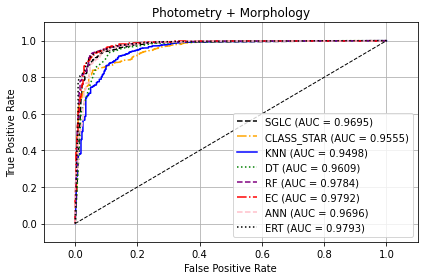

In [14]:
for y_test_m, values, label, clr, ls \
        in zip([y_test['r_extendedness_value'], y_test['r_extendedness_value'],y_test['r_extendedness_value'], y_test['r_extendedness_value'],y_test['r_extendedness_value'], y_test['r_extendedness_value'],y_test['r_extendedness_value'], y_test['r_extendedness_value']],\
        [y_test['pdf'],y_test['class_Sextractor'], knn_test, dt_test, rf_test, el_test, nn_test, ert_test],\
               clf_labels, colors, linestyles):

    fpr, tpr, thresholds = roc_curve(y_true=y_test_m, y_score=values, pos_label=1)
    roc_auc = auc(x=fpr, y=tpr)
    
    #fig, ax = plt.subplots()
    
    #lc = colorline(fpr, tpr, thresholds)
    
    #fig.colorbar(lc)
    
    #plot_roc(tpr,fpr,thresholds)
    #plt.colorbar(lc)
    plt.plot(fpr, tpr,color=clr,linestyle=ls,label='%s (AUC = %0.4f)' % (label, roc_auc))
      
#plt.colorbar(lc)           
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', linewidth=1)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Photometry + Morphology')
plt.savefig('./morpho_roc_HSC.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show() 
plt.close()

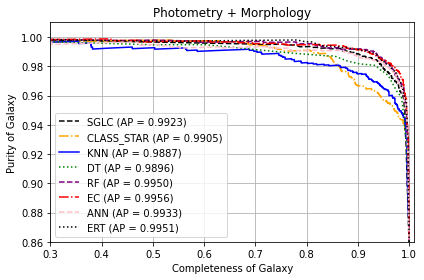

In [15]:
# Precision - Recall

# precision= purity  ;recall= sensitivity or completeness
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve


# pos =0  -> [1-y_test['class_SDSS'],1-y_test['class_SDSS']],[y_test['class_Sextractor'],1-rf_test]    (star truth)
# pos =0  -> [y_test['class_SDSS'],y_test['class_SDSS']],[1-y_test['class_Sextractor'],rf_test]        (galaxy truth)



for y_test_m, values, label, clr, ls \
        in zip([y_test['r_extendedness_value'], y_test['r_extendedness_value'],y_test['r_extendedness_value'], y_test['r_extendedness_value'],y_test['r_extendedness_value'], y_test['r_extendedness_value'],y_test['r_extendedness_value'], y_test['r_extendedness_value']],\
        [y_test['pdf'],y_test['class_Sextractor'], knn_test, dt_test, rf_test, el_test, nn_test, ert_test],\
               clf_labels, colors, linestyles):

    precision, recall, thresholds = precision_recall_curve(y_test_m, values, pos_label=1)
    #roc_auc = auc(x=recall, y=precision)
    #print(precision)
    #print(recall)
    
    #lc = colorline(recall, precision, thresholds)
    average_precision = average_precision_score(y_test_m, values)
    plt.plot(recall, precision, color=clr,linestyle=ls,label='%s (AP = %0.4f)' % (label, average_precision))
      
#plt.colorbar(lc)           
plt.legend(loc='lower left')
#plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)


#plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness of Galaxy')
plt.ylabel('Purity of Galaxy')
plt.ylim([0.86, 1.01])
plt.xlim([0.3, 1.01])
plt.title('Photometry + Morphology')
#plt.savefig('./morpho_galaxy_precision_recall_HSC.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show() 
plt.close()

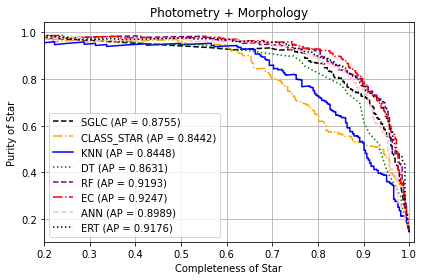

In [16]:
for y_test_m, values, label, clr, ls \
        in zip([1-y_test['r_extendedness_value'], 1-y_test['r_extendedness_value'], 1-y_test['r_extendedness_value'], 1-y_test['r_extendedness_value'], 1-y_test['r_extendedness_value'], 1-y_test['r_extendedness_value'], 1-y_test['r_extendedness_value'], 1-y_test['r_extendedness_value']],\
        [1-y_test['pdf'],1-y_test['class_Sextractor'], 1-knn_test, 1-dt_test, 1-rf_test, 1-el_test, 1-nn_test, 1-ert_test],\
               clf_labels, colors, linestyles):

    precision, recall, thresholds = precision_recall_curve(y_test_m, values,pos_label=1)
    #roc_auc = auc(x=recall, y=precision)
    #print(precision)
    #print(recall)
    
    #lc = colorline(recall, precision, thresholds)
    average_precision = average_precision_score(y_test_m, values)
    plt.plot(recall, precision, color=clr,linestyle=ls,label='%s (AP = %0.4f)' % (label, average_precision))
      
#plt.colorbar(lc)           
plt.legend(loc='lower left')
#plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlim([0.2, 1.01])
#plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness of Star')
plt.ylabel('Purity of Star')

plt.title('Photometry + Morphology')
#plt.savefig('./morpho_star_precision_recall_HSC.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show() 
plt.close()

In [17]:
# Feature Importance

feat_labels = df.columns[12:]

feature_importance = loaded_model_rf.feature_importances_
importances = (feature_importance / feature_importance.max())

# Orders the means of impurity from highest to lowest
indices = np.argsort(importances)[::-1]					#  [::-1]	-> make a copy of the same list in reverse order:


for f in range(x_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,  feat_labels[indices[f]], importances[indices[f]]))
                            

 1) c_r                            1.000000
 2) iSDSSerr                       0.186659
 3) fwhm                           0.184177
 4) mu_max_mag_apertu              0.165709
 5) TILE_ID                        0.110336
 6) J0390err                       0.027594
 7) J0820err                       0.022943
 8) J0740                          0.015768
 9) alb                            0.012513
10) J0390                          0.011452
11) uJAVAerr                       0.010256
12) gSDSS                          0.010071
13) J0740err                       0.007614
14) J0680err                       0.007204
15) J0760err                       0.007161
16) J1007err                       0.007125
17) uJAVA                          0.006954
18) gSDSSerr                       0.006794
19) J0680                          0.006491
20) J0750err                       0.006224
21) J0790err                       0.006163
22) J0660err                       0.006143
23) rSDSSerr                    

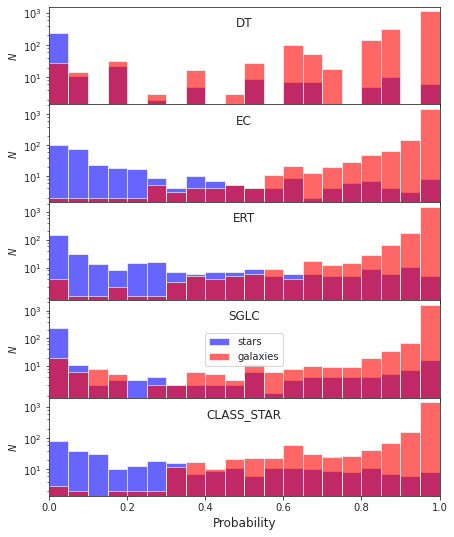

In [18]:
# Histogram Probability 
import matplotlib


bins = np.linspace(0, 1, 21)
log = True
normed = False
alpha = 0.6

ylim_upper = 2*10**4

#sns.color_palette("RdBu", n_colors=30)
sns.set_style("ticks")

fig = plt.figure(figsize=(7, 9))
plt.subplots_adjust(hspace=0.001)


ax0 = plt.subplot(511)
ax0.hist(dt_test[y_test['r_extendedness_value'] == 0], bins=bins, log=log, label='stars', alpha=alpha, color='blue')
ax0.hist(dt_test[y_test['r_extendedness_value'] == 1], bins=bins, log=log, label='galaxies', alpha=alpha, color='red')

#ax0.legend(loc='upper center')
ax0.set_xlim(0, 1)
#ax0.set_ylim(1, ylim_upper)
ax0.set_ylabel(r'$N$')
ax0.get_yaxis().set_tick_params(which='both', direction='out')
ax0.text(.5,.8,'DT',horizontalalignment='center', fontsize=12, transform=ax0.transAxes)
ax0.set_yticks([10**1, 10**2, 10**3])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())



ax1 = plt.subplot(512)
ax1.hist(el_test[y_test['r_extendedness_value'] == 0], bins=bins, log=log, label='stars', alpha=alpha, color='blue')
ax1.hist(el_test[y_test['r_extendedness_value'] == 1], bins=bins, log=log, label='galaxies', alpha=alpha, color='red')

#ax1.legend(loc='upper center')
ax1.set_xlim(0, 1)
#ax1.set_ylim(1, ylim_upper)
ax1.set_ylabel(r'$N$')
ax1.get_yaxis().set_tick_params(which='both', direction='out')
ax1.text(.5,.8,'EC',horizontalalignment='center', fontsize=12, transform=ax1.transAxes)
ax1.set_yticks([10**1, 10**2, 10**3])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())




ax2 = plt.subplot(513)
ax2.hist(ert_test[y_test['r_extendedness_value'] == 0], bins=bins, log=log, label='stars', alpha=alpha, color='blue')
ax2.hist(ert_test[y_test['r_extendedness_value'] == 1], bins=bins, log=log, label='galaxies', alpha=alpha, color='red')
#ax2.legend(loc='upper center')
ax2.set_xlim(0, 1)
#ax2.set_ylim(1, ylim_upper)
ax2.set_ylabel(r'$N$')
ax2.get_yaxis().set_tick_params(which='both', direction='out')
ax2.text(.5,.8,'ERT', horizontalalignment='center', fontsize=12,transform=ax2.transAxes)
ax2.set_yticks([10**1, 10**2, 10**3])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())



ax3 = plt.subplot(514, sharex=ax1)
ax3.hist(y_test['pdf'][y_test['r_extendedness_value'] == 0], bins=bins, log=log, label='stars', alpha=alpha, color='blue')
ax3.hist(y_test['pdf'][y_test['r_extendedness_value'] == 1], bins=bins, log=log, label='galaxies', alpha=alpha, color='red')
ax3.legend(loc='center')
ax3.set_xlim(0, 1)
#ax3.set_ylim(1, ylim_upper)
ax3.set_ylabel(r'$N$')
#ax3.set_xlabel(r'$P\,\left(S\right)$', fontsize=12)
ax3.get_yaxis().set_tick_params(which='both', direction='out')
ax3.text(.5,.8,'SGLC', horizontalalignment='center',transform=ax3.transAxes, fontsize=12)
ax3.set_yticks([10**1, 10**2, 10**3])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax3.yaxis.set_minor_locator(locmin)
ax3.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())



ax4 = plt.subplot(515, sharex=ax1)
ax4.hist(y_test['class_Sextractor'][y_test['r_extendedness_value'] == 0], bins=bins, log=log, label='stars', alpha=alpha, color='blue')
ax4.hist(y_test['class_Sextractor'][y_test['r_extendedness_value'] == 1], bins=bins, log=log, label='galaxies', alpha=alpha, color='red')
#ax4.legend(loc='upper right')
ax4.set_xlim(0, 1)
#ax4.set_ylim(1, ylim_upper)
ax4.set_ylabel(r'$N$')
ax4.set_xlabel('Probability', fontsize=12)
ax4.get_yaxis().set_tick_params(which='both', direction='out')
ax4.text(.5,.8,'CLASS_STAR', horizontalalignment='center', transform=ax4.transAxes, fontsize=12)
#ax4.set_yscale("log", nonposy='clip')
ax4.set_yticks([10**1, 10**2, 10**3])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax4.yaxis.set_minor_locator(locmin)
ax4.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())



xticklabels =  ax0.get_xticklabels() + ax1.get_xticklabels() + ax2.get_xticklabels() + ax3.get_xticklabels()
plt.setp(xticklabels, visible=False)
#fig.suptitle('Histogram Probability Morpho HSC')
#plt.savefig('./hist_prob_morpho_HSC.pdf', bbox_inches='tight')
plt.show()
plt.close()

/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexe

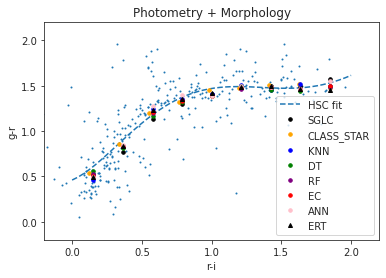

In [19]:
# Stellar Locus

from scipy import stats 

data = pd.DataFrame({'Sextractor':y_test['class_Sextractor'], 'SDSS': y_test['r_extendedness_value'], 'pdf': y_test['pdf'], 'KNN': knn_test, 'DT': dt_test ,'RF': rf_test, 'ENSEMBLE': el_test, 'NN': nn_test, 'ERT': ert_test,'r': x_test['rSDSS'], 'g-r': x_test['gSDSS']-x_test['rSDSS'], 'r-i': x_test['rSDSS']-x_test['iSDSS']}) 

#reordening columns
data = data[['SDSS','pdf','Sextractor','KNN','DT','RF','ENSEMBLE','NN','ERT','r','g-r','r-i']]

# SDSS
df_sdss = data[data['g-r'].between(-0.5,2, inclusive=True)][data['r-i'].between(-0.5,2, inclusive=True)][data['SDSS']==0]

y_sdss = df_sdss['g-r']
x_sdss = df_sdss['r-i']

# calculate polynomial
z = np.polyfit(x_sdss, y_sdss, 5)
f = np.poly1d(z)

x_new = np.linspace(-0.0, 2, 50)
y_new = f(x_new)


# dataframe ML
df_pdf = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['pdf']<=0.5]
df_sex = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['Sextractor']<=0.5]
df_knn = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['KNN']<=0.5]
df_dt = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['DT']<=0.5]
df_rf = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['RF']<=0.5]
df_el = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['ENSEMBLE']<=0.5]
df_nn = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['NN']<=0.5]
df_ert = data[data['g-r'].between(0,2, inclusive=True)][data['r-i'].between(0,2, inclusive=True)][data['ERT']<=0.5]


y_pdf = df_pdf['g-r']
x_pdf = df_pdf['r-i']

mean_pdf = stats.binned_statistic(x_pdf, y_pdf, statistic='mean', bins=9, range=None)
std_pdf  = stats.binned_statistic(x_pdf, y_pdf, statistic='std', bins=9, range=None)

y_sex = df_sex['g-r']
x_sex = df_sex['r-i']

mean_sex = stats.binned_statistic(x_sex, y_sex, statistic='mean', bins=9, range=None)
std_sex  = stats.binned_statistic(x_sex, y_sex, statistic='std', bins=9, range=None)


y_knn = df_knn['g-r']
x_knn = df_knn['r-i']

mean_knn = stats.binned_statistic(x_knn, y_knn, statistic='mean', bins=9, range=None)
std_knn  = stats.binned_statistic(x_knn, y_knn, statistic='std', bins=9, range=None)



y_dt = df_dt['g-r']
x_dt = df_dt['r-i']

mean_dt = stats.binned_statistic(x_dt, y_dt, statistic='mean', bins=9, range=None)
std_dt  = stats.binned_statistic(x_dt, y_dt, statistic='std', bins=9, range=None)


y_rf = df_rf['g-r']
x_rf = df_rf['r-i']

mean_rf = stats.binned_statistic(x_rf, y_rf, statistic='mean', bins=9, range=None)
std_rf  = stats.binned_statistic(x_rf, y_rf, statistic='std', bins=9, range=None)

y_el = df_el['g-r']
x_el = df_el['r-i']

mean_el = stats.binned_statistic(x_el, y_el, statistic='mean', bins=9, range=None)
std_el  = stats.binned_statistic(x_el, y_el, statistic='std', bins=9, range=None)

y_nn = df_nn['g-r']
x_nn = df_nn['r-i']

mean_nn = stats.binned_statistic(x_nn, y_nn, statistic='mean', bins=9, range=None)
std_nn  = stats.binned_statistic(x_nn, y_nn, statistic='std', bins=9, range=None)


y_ert = df_ert['g-r']
x_ert = df_ert['r-i']

mean_ert = stats.binned_statistic(x_ert, y_ert, statistic='mean', bins=9, range=None)
std_ert  = stats.binned_statistic(x_ert, y_ert, statistic='std', bins=9, range=None)



# error
#plt.errorbar((mean_pdf[1][1:] + mean_pdf[1][:-1])/2, mean_pdf[0], yerr=std_pdf[0] , fmt='.', mfc='black', ecolor='black',mec='black', ms=3) # understand yerr=std_ML, 

# Plot
plt.errorbar((mean_pdf[1][1:] + mean_pdf[1][:-1])/2, mean_pdf[0],  fmt='.', mfc='black', ecolor='black',mec='black', ms=7) # understand yerr=std_ML, 
plt.errorbar((mean_sex[1][1:] + mean_sex[1][:-1])/2, mean_sex[0],  fmt='.', mfc='orange', ecolor='orange',mec='orange', ms=7) # understand yerr=std_ML, 
plt.errorbar((mean_knn[1][1:] + mean_knn[1][:-1])/2, mean_knn[0],  fmt='.', mfc='blue', ecolor='blue',mec='blue', ms=7) # understand yerr=std_ML, 
plt.errorbar((mean_dt[1][1:] + mean_dt[1][:-1])/2, mean_dt[0],  fmt='.', mfc='green', ecolor='green',mec='green', ms=7) # understand yerr=std_ML, 
plt.errorbar((mean_rf[1][1:] + mean_rf[1][:-1])/2, mean_rf[0],  fmt='.', mfc='purple', ecolor='purple',mec='purple', ms=7) # understand yerr=std_ML, 
plt.errorbar((mean_el[1][1:] + mean_el[1][:-1])/2, mean_el[0],  fmt='.', mfc='red', ecolor='red',mec='red', ms=7) # understand yerr=std_ML, 
plt.errorbar((mean_nn[1][1:] + mean_nn[1][:-1])/2, mean_nn[0],   fmt='.', mfc='pink', ecolor='pink',mec='pink', ms=7) # understand yerr=std_ML, 
plt.errorbar((mean_ert[1][1:] + mean_ert[1][:-1])/2, mean_ert[0],  fmt='^', mfc='black', ecolor='black',mec='black', ms=4) # understand yerr=std_ML, 


#plt.title('Stellar Locus morpho HSC')
#plt.scatter(x_sdss, y_sdss, s=1, color='blue')
plt.plot(x_new, f(x_new),'--')
plt.xlabel('r-i')
plt.ylabel('g-r')
plt.legend(('HSC fit','SGLC','CLASS_STAR','KNN','DT','RF','EC','ANN','ERT'), loc='lower right')
plt.scatter(x_sdss, y_sdss, s=1)
plt.title('Photometry + Morphology')
#plt.savefig('./stellar_locus_morpho_HSC.pdf', bbox_inches='tight')
plt.ylim(-0.2,2.2)
plt.xlim(-0.2,2.2)
plt.show()
plt.close()
